# How to create custom dataset



In [33]:
import numpy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [34]:
transformations1 = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.Grayscale(1),
                                      transforms.RandomVerticalFlip(0.5),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor()])

train = ImageFolder('/home/bvieuble/Master/Train2/', transform=transformations1)
test = ImageFolder('/home/bvieuble/Master/Test2/', transform=transformations1)

dataloader_args = dict(shuffle=True, batch_size=32,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

0
torch.Size([1, 64, 64])


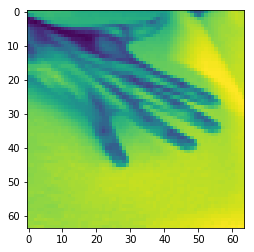

In [35]:
img,label = train.__getitem__(50)
print (label)
print (img.shape)
plt.imshow(img.squeeze(0).permute(0,1))

In [36]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(64*64, 1000)
        self.fc2 = nn.Linear(1000, 3)
    def forward(self, x):
        x = x.view((-1, 4096))
        h = F.relu(self.fc1(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
EPOCHS = 5
losses = []


# Eval
evaluate_x, evaluate_y = iter(test_loader).next()
evaluate_x = evaluate_x.unsqueeze_(1)


if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)
batch_size = (train_size / 256) if (cuda) else  (train_size / 64)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data.permute(0,1,2,3)) 
         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [172/172 (186%)]	Loss: 1.600462	 Test Accuracy: 26.6667%
 Train Epoch: 2/5 [172/172 (186%)]	Loss: 1.167696	 Test Accuracy: 26.6667%
 Train Epoch: 3/5 [172/172 (186%)]	Loss: 1.507067	 Test Accuracy: 33.3333%
 Train Epoch: 4/5 [172/172 (186%)]	Loss: 1.034144	 Test Accuracy: 36.6667%
 Train Epoch: 5/5 [172/172 (186%)]	Loss: 1.093394	 Test Accuracy: 20.0000%
